# Movie Rating Prediction

## Data Cleaning & EDA

This notebook contains code for the data cleaning and EDA for this project.

**Table of Contents**

1. [Data Cleaning](#Data-Cleaning)
  1. [Synopsis Strings](#Synopsis-Strings)
  2. [Genre IDs](#Genre-IDs)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  1. [Rating Distributions by Genre](#Rating-Distributions-by-Genre)
  2. [Synopsis Features](#Synopsis-Features)
  3. [Time of Release](#Time-of-Release)
 

To begin, we load the dependencies for this project and the data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime as dt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
from PIL import Image

In [6]:
movies = pd.read_csv("../data/tmdb_api_data.csv", lineterminator="\n")
display(movies.head())
genres = pd.read_csv("../data/tmdb_genres.csv")
display(genres.head())

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/bOGkgRGdhrBYJSLpXaxhXVstddV.jpg,"[12, 28, 14]",299536,en,Avengers: Infinity War,As the Avengers and their allies have continue...,153.811,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,2018-04-25,Avengers: Infinity War,False,8.3,12490
1,False,/5zfVNTrkhMu673zma6qhFzG01ig.jpg,[878],300668,en,Annihilation,"A biologist signs up for a dangerous, secret e...",29.516,/d3qcpfNwbAMCNqWDHzPQsUYiUgS.jpg,2018-02-22,Annihilation,False,6.3,4232
2,False,/zjG95oDnBcFKMPgBEmmuNVOMC90.jpg,"[35, 18]",299782,en,The Other Side of the Wind,"Surrounded by fans and skeptics, grizzled dire...",6.820,/kFky1paYEfHxfCYByEc9g7gn6Zk.jpg,2018-11-02,The Other Side of the Wind,False,7.1,55
3,False,/q9hnJ9SzwcF30seRtXEzLd5l1gw.jpg,"[18, 35, 14]",351044,en,Welcome to Marwen,When a devastating attack shatters Mark Hoganc...,61.973,/o45VIAUYDcVCGuzd43l8Sr5Dfti.jpg,2018-12-21,Welcome to Marwen,False,6.6,174
4,False,/AmO8I38bkHwKhgxPNrd6djBQyPU.jpg,"[53, 9648, 27, 14]",361292,en,Suspiria,A darkness swirls at the center of a world-ren...,41.461,/dzWTnkert9EoiPWldWJ15dnfAFl.jpg,2018-10-11,Suspiria,False,7.2,579


,id,name
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime


In [7]:
movies["image_url"] = "http://image.tmdb.org/t/p/w185/" + movies["poster_path"]

In [10]:
Image.open()

FileNotFoundError: [Errno 2] No such file or directory: 'http://image.tmdb.org/t/p/w185//7WsyChQLEftFiDOVTGkv3hFpyyt.jpg'

In [12]:
import urllib

The `movies` dataframe contains data on each English language movie released in 2018. The columns of interest are described below. A full description of all columns can be found in the [TMDb API documentation](https://developers.themoviedb.org/3/getting-started/popularity).

| Column | Description |
|-----|-----|
| adult | T/F whether or not the movie is adult (R+ rated) |
| genre_ids | ID numbers corresponding to genres in the `genres` dataframe |
| id | **primary key**; a unique identifier for each movie
| original_language | the language the movie was released in originally |
| original_title | the title of the movie |
| overview | synopsis of the movie | 
| release_date | date of first release |
| vote_average | average of votes on a 10-point scale |
| vote_count | number of votes |

The `genres` dataframe consists of a column `id` with the numerical ID for the genre and the genre `name`.

## Data Cleaning

In this section, we clean the data so that we can perform EDA on the data set and begin to select important features for the model.

### Synopsis Strings

We begin by cleaning the synopsis strings, which need to be changed to lower case and have all non-letter and non-numeric characters removed. The first is accomplished using `pd.Series.str.lower` and the latter by using `pd.Series.str.replace` in conjunction with a regex to select out the undesired characters/

In [3]:
movies["overview"] = movies["overview"].str.lower()

In [4]:
movies["overview"] = movies["overview"].str.replace(r"[^A-Za-z0-9 ]", " ")

In [5]:
movies["overview"].head()

0    as the avengers and their allies have continue...
1    a biologist signs up for a dangerous  secret e...
2    surrounded by fans and skeptics  grizzled dire...
3    when a devastating attack shatters mark hoganc...
4    a darkness swirls at the center of a world ren...
Name: overview, dtype: object

### Genre IDs

We now need to get the genres into a form more conducive to analyzing distributions within and across genres. To begin, we change all empty lists of genre IDs to `nan` using `np.nan` and Python's ternary operator.

In [6]:
genre_list = [(np.nan, genre)[genre != "[]"] for genre in movies["genre_ids"]]
movies["genre_ids"] = genre_list

Next, we remove the square brackets from each string in `genre_ids` and then split the IDs into lists using `str.split`.

In [7]:
movies["genre_ids"] = movies["genre_ids"].str.replace(r"[\[\]]", "").str.split(", ")

Now, we have a `genre_ids` column where each entry is a list and where we can filter out `nan` values.

In [8]:
movies["genre_ids"].isna().head(10)

0    False
1    False
2    False
3    False
4    False
5     True
6    False
7    False
8    False
9     True
Name: genre_ids, dtype: bool

To replace the genre IDs with their corresponding strings, we first convert the numeric IDs in the `id` column of `genres` to strings and then create a dictionary which maps each ID to its genre name.

In [9]:
genres["id"] = genres["id"].astype(str)
genre_dict = {d["id"] : d["name"] for d in genres.to_dict(orient="records")}
genre_dict

{'10402': 'Music',
 '10749': 'Romance',
 '10751': 'Family',
 '10752': 'War',
 '10770': 'TV Movie',
 '12': 'Adventure',
 '14': 'Fantasy',
 '16': 'Animation',
 '18': 'Drama',
 '27': 'Horror',
 '28': 'Action',
 '35': 'Comedy',
 '36': 'History',
 '37': 'Western',
 '53': 'Thriller',
 '80': 'Crime',
 '878': 'Science Fiction',
 '9648': 'Mystery',
 '99': 'Documentary'}

We now apply the change by iterating through the rows of the `movies` dataframe and then iterating through each ID in the `genre_ids` column, using the dictionary to get the names corresponding to each ID. These are collected in a list, which is then added to the `movies` dataframe as a `genres` column, before the `genre_ids` column is dropped.

In [10]:
genres_as_words = []
for row in range(movies.shape[0]):
    genre_ids = movies["genre_ids"].iloc[row]
    new_genres = []
    try:
        for genre in genre_ids:
            new_genres += [genre_dict[genre]]
    except TypeError:
        new_genres = np.nan
    genres_as_words += [new_genres]
    
movies["genres"] = genres_as_words
movies.drop("genre_ids", axis=1, inplace=True)
movies.head()

,adult,backdrop_path,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,genres
0,False,/bOGkgRGdhrBYJSLpXaxhXVstddV.jpg,299536,en,Avengers: Infinity War,as the avengers and their allies have continue...,153.811,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,2018-04-25,Avengers: Infinity War,False,8.3,12490,"[Adventure, Action, Fantasy]"
1,False,/5zfVNTrkhMu673zma6qhFzG01ig.jpg,300668,en,Annihilation,a biologist signs up for a dangerous secret e...,29.516,/d3qcpfNwbAMCNqWDHzPQsUYiUgS.jpg,2018-02-22,Annihilation,False,6.3,4232,[Science Fiction]
2,False,/zjG95oDnBcFKMPgBEmmuNVOMC90.jpg,299782,en,The Other Side of the Wind,surrounded by fans and skeptics grizzled dire...,6.820,/kFky1paYEfHxfCYByEc9g7gn6Zk.jpg,2018-11-02,The Other Side of the Wind,False,7.1,55,"[Comedy, Drama]"
3,False,/q9hnJ9SzwcF30seRtXEzLd5l1gw.jpg,351044,en,Welcome to Marwen,when a devastating attack shatters mark hoganc...,61.973,/o45VIAUYDcVCGuzd43l8Sr5Dfti.jpg,2018-12-21,Welcome to Marwen,False,6.6,174,"[Drama, Comedy, Fantasy]"
4,False,/AmO8I38bkHwKhgxPNrd6djBQyPU.jpg,361292,en,Suspiria,a darkness swirls at the center of a world ren...,41.461,/dzWTnkert9EoiPWldWJ15dnfAFl.jpg,2018-10-11,Suspiria,False,7.2,579,"[Thriller, Mystery, Horror, Fantasy]"


### Filtering `nan` Rows

Before we can movie on, we first need to get an idea of how many rows have values in the `vote_average` and `vote_count` columns that do not make sense. We only want rows where the rating is nonzero *or* where there is at least one vote.

In [11]:
print("Total number of movies: {}".format(movies.shape[0]))
print("Movies with nonzero rating: {}".format(movies[movies["vote_average"] != 0].shape[0]))
print("Movies with nonzero vote count: {}".format(movies[movies["vote_count"] != 0].shape[0]))

Total number of movies: 8473
Movies with nonzero rating: 2735
Movies with nonzero vote count: 2802


In the cell below, we filter the rows that either have a nonzero rating or at least 1 vote.

In [12]:
movies = movies[(movies["vote_average"] != 0) | (movies["vote_count"] != 0)]

Finally, before moving on to some EDA, we extract the columns that are of interest from the `movies` dataframe.

In [13]:
# extract variables of interest
movies = movies[["id", "title", "overview", "genres", "release_date", "adult", "vote_count", "vote_average"]]
movies.head()

,id,title,overview,genres,release_date,adult,vote_count,vote_average
0,299536,Avengers: Infinity War,as the avengers and their allies have continue...,"[Adventure, Action, Fantasy]",2018-04-25,False,12490,8.3
1,300668,Annihilation,a biologist signs up for a dangerous secret e...,[Science Fiction],2018-02-22,False,4232,6.3
2,299782,The Other Side of the Wind,surrounded by fans and skeptics grizzled dire...,"[Comedy, Drama]",2018-11-02,False,55,7.1
3,351044,Welcome to Marwen,when a devastating attack shatters mark hoganc...,"[Drama, Comedy, Fantasy]",2018-12-21,False,174,6.6
4,361292,Suspiria,a darkness swirls at the center of a world ren...,"[Thriller, Mystery, Horror, Fantasy]",2018-10-11,False,579,7.2


## Exploratory Data Analysis

In this section, we want to learn about the relationships between the data in our training set so that we can choose some good features to build the linear regression predictor on.

To begin. we look at the relationship between the number of votes and the average rating.

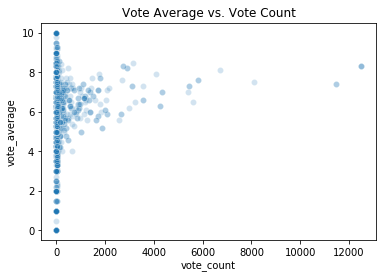

In [21]:
sns.scatterplot("vote_count", "vote_average", data=movies, alpha=0.2)
plt.title("Vote Average vs. Vote Count")
plt.savefig("../figures/average-vs-count.png");

To look at the relationship between whether or not a movie is adult and its average rating, we first need to encode the `adult` column numerically (1 for true, 0 for false).

In [13]:
movies["adult"] = movies["adult"].astype(int)

Now, we look at the overlaid histograms of the distributions of ratings for adult and non-adult movies. Seaborn also plots a kernel density estimate (KDE) in the figure for each group.

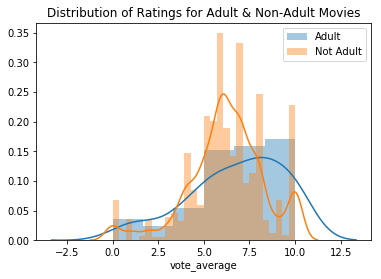

In [22]:
sns.distplot(movies[movies["adult"] == 1]["vote_average"], label="Adult")
sns.distplot(movies[movies["adult"] == 0]["vote_average"], label="Not Adult")
plt.title("Distribution of Ratings for Adult & Non-Adult Movies")
plt.legend()
plt.savefig("../figures/dist-adult-non-adult.png");

The distributions are definitely different for adult and non-adult movies, with non-adult movies having a peak at a lower score and less spread about the maximum than the adult movies.

### Rating Distributions by Genre

Next, we want to get an idea of the distributions of averages by genre, so we define the helper function `genre_in_list` to determine if the lists in the `genres` column contains the genre string.

In [23]:
def genre_in_list(genre, lst):
    """
    Helper function to determine if a list contains the string `genre`
    """
    try:
        return genre in lst
    except TypeError:
        return False

We now expand the `genres` column with 1 column for each genre where the value is 0 if the `genres` list for that row does *not* contain the genre and 1 if it does. (This also handily one-hot encodes the `genre` variable for us.)

In [24]:
for genre in genre_dict.values():
    is_genre = movies["genres"].apply(lambda x: genre_in_list(genre, x))
    movies[genre] = is_genre.astype(int)
    
movies.head()

,id,title,overview,genres,release_date,adult,vote_count,vote_average,Action,Adventure,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,299536,Avengers: Infinity War,as the avengers and their allies have continue...,"[Adventure, Action, Fantasy]",2018-04-25,False,12490,8.3,1,1,...,0,0,0,0,0,0,0,0,0,0
1,300668,Annihilation,a biologist signs up for a dangerous secret e...,[Science Fiction],2018-02-22,False,4232,6.3,0,0,...,0,0,0,0,0,1,0,0,0,0
2,299782,The Other Side of the Wind,surrounded by fans and skeptics grizzled dire...,"[Comedy, Drama]",2018-11-02,False,55,7.1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,351044,Welcome to Marwen,when a devastating attack shatters mark hoganc...,"[Drama, Comedy, Fantasy]",2018-12-21,False,174,6.6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,361292,Suspiria,a darkness swirls at the center of a world ren...,"[Thriller, Mystery, Horror, Fantasy]",2018-10-11,False,579,7.2,0,0,...,0,1,0,1,0,0,0,1,0,0


Now, to look at the distributions by genre, we define a function to iterate through the genres and plots an overlaid histogram with KDE of the average ratings for movies of and not of that genre.

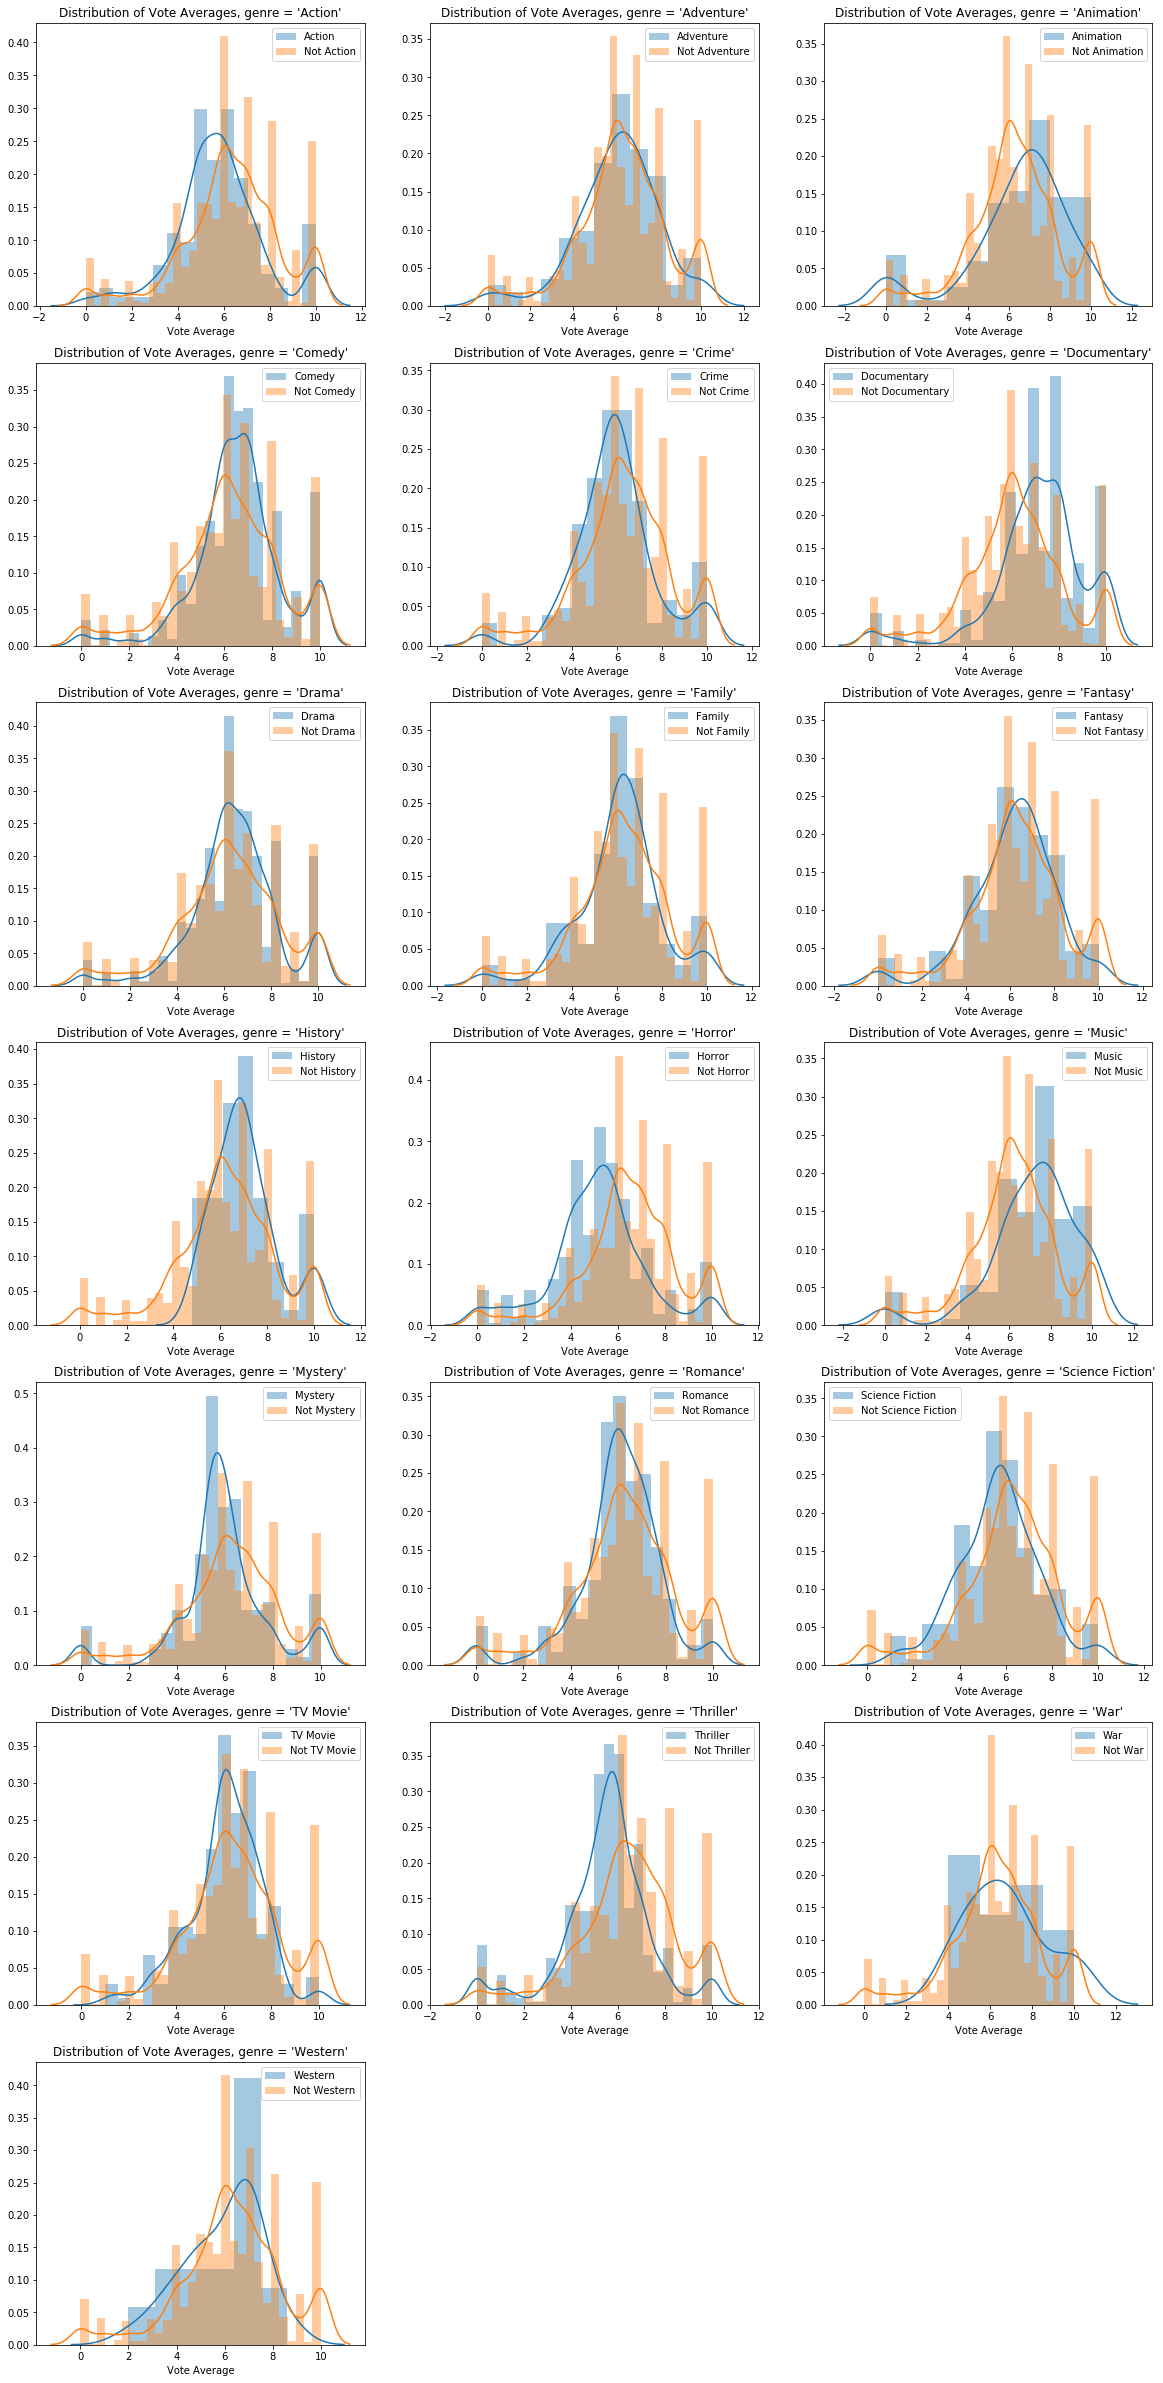

In [28]:
def plot_vote_avg_dist_by_genre():
    plt.figure(figsize=[20, 30])
    i = 1
    for genre in list(genre_dict.values()):
        desired_genre = movies[movies[genre] == 1]
        not_desired_genre = movies[movies[genre] != 1]
        
        plt.subplot(7, 3, i)
        sns.distplot(desired_genre["vote_average"], label=genre)
        sns.distplot(not_desired_genre["vote_average"], label="Not {}".format(genre))
        plt.title("Distribution of Vote Averages, genre = '{}'".format(genre))
        plt.xlabel("Vote Average")
        plt.legend()
        
        i += 1
        
    plt.subplots_adjust(top=1.2)
    plt.savefig("../figures/rating-dists-by-genre.png", bbox_inches="tight")
    
plot_vote_avg_dist_by_genre()

### Synopsis Features

Now we want to see if there is a relationship between the length of a synopsis (the number of characters) and the average rating. To do this, we add a column `overview_len` to the `movies` dataframe which contains the length of each synopsis.

In [29]:
movies["overview_len"] = movies["overview"].str.len()

We now plot a scatterplot of the overview lengths vs. the average rating.

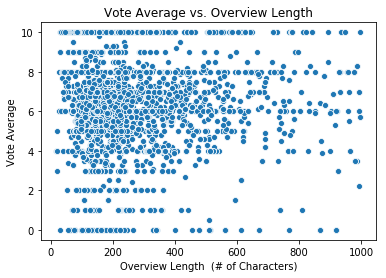

In [33]:
sns.scatterplot("overview_len", "vote_average", data=movies)
plt.title("Vote Average vs. Overview Length")
plt.xlabel("Overview Length  (# of Characters)")
plt.ylabel("Vote Average")
plt.savefig("../figures/average-vs-overview-len.png");

To get an idea of how the presence of certain words affects the distribution of average ratings, we first drop rows that have `nan` values in the `overview` column and then collect each word in a Series. Then we create a dictionary where each key corresponds to a unique word and the values are the number of synopses that contain that word.

In [34]:
plots = movies.dropna(subset=["overview"])["overview"]

words = []
for plot in plots:
    for word in plot.split(" "): 
        words += [word]
        
words = pd.Series(words).unique()            
word_counts = {}
for word in words:
    count = sum(plots.str.contains(word))
    word_counts[word] = count

To get an idea of the frequencies of some words, we look at the number of appearances for "avenge", "love", and "money".

In [35]:
for word in ["avenge", "love", "money"]:
    print("{}: {} appearances".format(word, word_counts[word]))

avenge: 15 appearances
love: 283 appearances
money: 42 appearances


In order to find good word features, we want to see how the presence of a word affects the distribution of ratings. To this end, we define the helper function `plot_vote_avg_dist_by_word` which takes in a word and plots the distribution of ratings for synopses that do and do not contain that word.

In [38]:
def plot_vote_avg_dist_by_word(word):
    """
    Plots overlaid histograms of distributions of ratings for synopses that
    do and do not contain `word`
    """
    not_nan_plots = movies.dropna(subset=["overview"])
    idx = not_nan_plots["overview"].str.contains(word)
    
    has_word = not_nan_plots[idx]
    no_word = not_nan_plots[~(idx)]
    
    plt.figure()
    sns.distplot(has_word["vote_average"], label="Present")
    sns.distplot(no_word["vote_average"], label="Not present")
    plt.title("Distribution of Vote Averages, word = '{}'".format(word))
    plt.xlabel("Vote Average")
    plt.legend()
    plt.savefig("../figures/eda-dist-by-word-{}.png".format(word))

We now plot the distributions as a demonstration for the words whose frequencies we checked above.

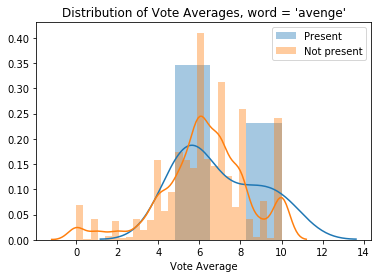

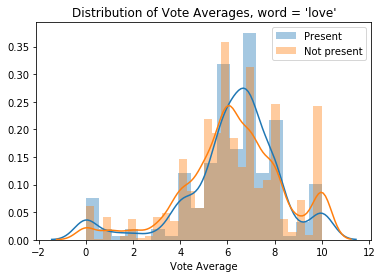

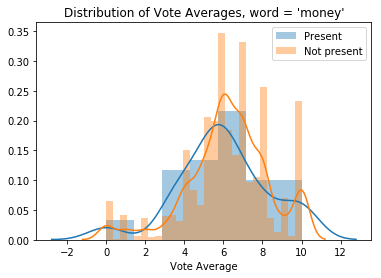

In [39]:
for word in ["avenge", "love", "money"]:
    plot_vote_avg_dist_by_word(word)

Now we want to look at word frequencies again to find potential features. We first create a dataframe with the word and its count from the `word_counts` dictionary. We then filter for words with more than 3 characters (to get rid of words like "a", "it", etc.) and at least 50 appearances (so that there is enough data about the word to draw conclusions from the distributions).

In [40]:
words_df = pd.DataFrame({
    "word" : list(word_counts.keys()),
    "count" : list(word_counts.values())
}).sort_values("count", ascending=False)

words_df[(words_df["word"].str.len() > 3) & (words_df["count"] > 50)]

,word,count
264,with,966
151,that,682
101,when,652
8384,heir,588
11,from,587
4,their,578
813,over,527
4689,ring,518
1118,come,444
117,life,440


I chose a few words that seemed like they might be somewhat discerning with regards to vote average and put them in `potential_word_features`. The code below plots the overlaid distributions using the `plot_vote_avg_dist_by_word` function.

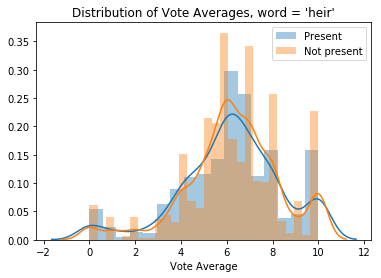

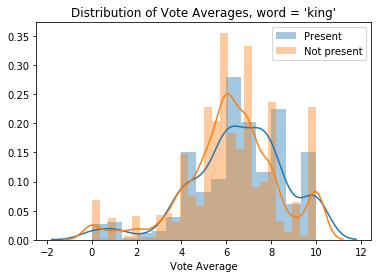

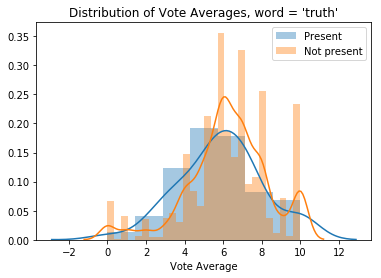

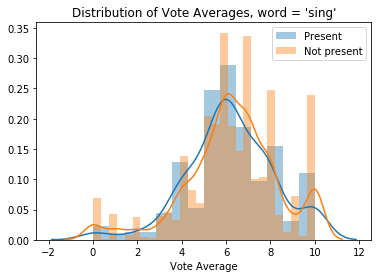

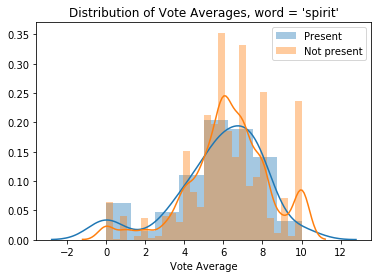

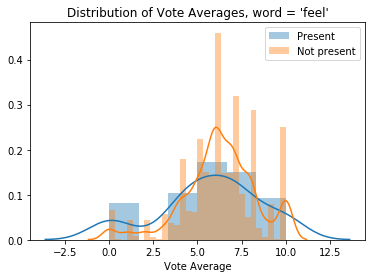

In [41]:
potential_word_features = ["heir", "king", "truth", "sing", "spirit", "feel"]
for word in potential_word_features:
    plot_vote_avg_dist_by_word(word)

### Time of Release

Finally, in this section, we look at how the release day and its aspects (e.g. month, time of month, day of week) can affect ratings. To begin, we first extract the month and day portions of the `release_date` strings as integers and place them into their own columns. We also use `dt.datetime.strftime` to extract the day of the week for the release date.

In [42]:
movies["month"] = [int(date[5:7]) for date in movies["release_date"]]
movies["day"] = [int(date[8:]) for date in movies["release_date"]]
movies["day_of_week"] = [dt.datetime.strptime(date, "%Y-%m-%d").strftime("%a") for date in movies["release_date"]]
movies.head()

,id,title,overview,genres,release_date,adult,vote_count,vote_average,Action,Adventure,...,Romance,Science Fiction,TV Movie,Thriller,War,Western,overview_len,month,day,day_of_week
0,299536,Avengers: Infinity War,as the avengers and their allies have continue...,"[Adventure, Action, Fantasy]",2018-04-25,False,12490,8.3,1,1,...,0,0,0,0,0,0,490.0,4,25,Wed
1,300668,Annihilation,a biologist signs up for a dangerous secret e...,[Science Fiction],2018-02-22,False,4232,6.3,0,0,...,0,1,0,0,0,0,116.0,2,22,Thu
2,299782,The Other Side of the Wind,surrounded by fans and skeptics grizzled dire...,"[Comedy, Drama]",2018-11-02,False,55,7.1,0,0,...,0,0,0,0,0,0,188.0,11,2,Fri
3,351044,Welcome to Marwen,when a devastating attack shatters mark hoganc...,"[Drama, Comedy, Fantasy]",2018-12-21,False,174,6.6,0,0,...,0,0,0,0,0,0,413.0,12,21,Fri
4,361292,Suspiria,a darkness swirls at the center of a world ren...,"[Thriller, Mystery, Horror, Fantasy]",2018-10-11,False,579,7.2,0,0,...,0,0,0,1,0,0,242.0,10,11,Thu


Now we plot the distributions of ratings by the day of the week on which the movie was released.

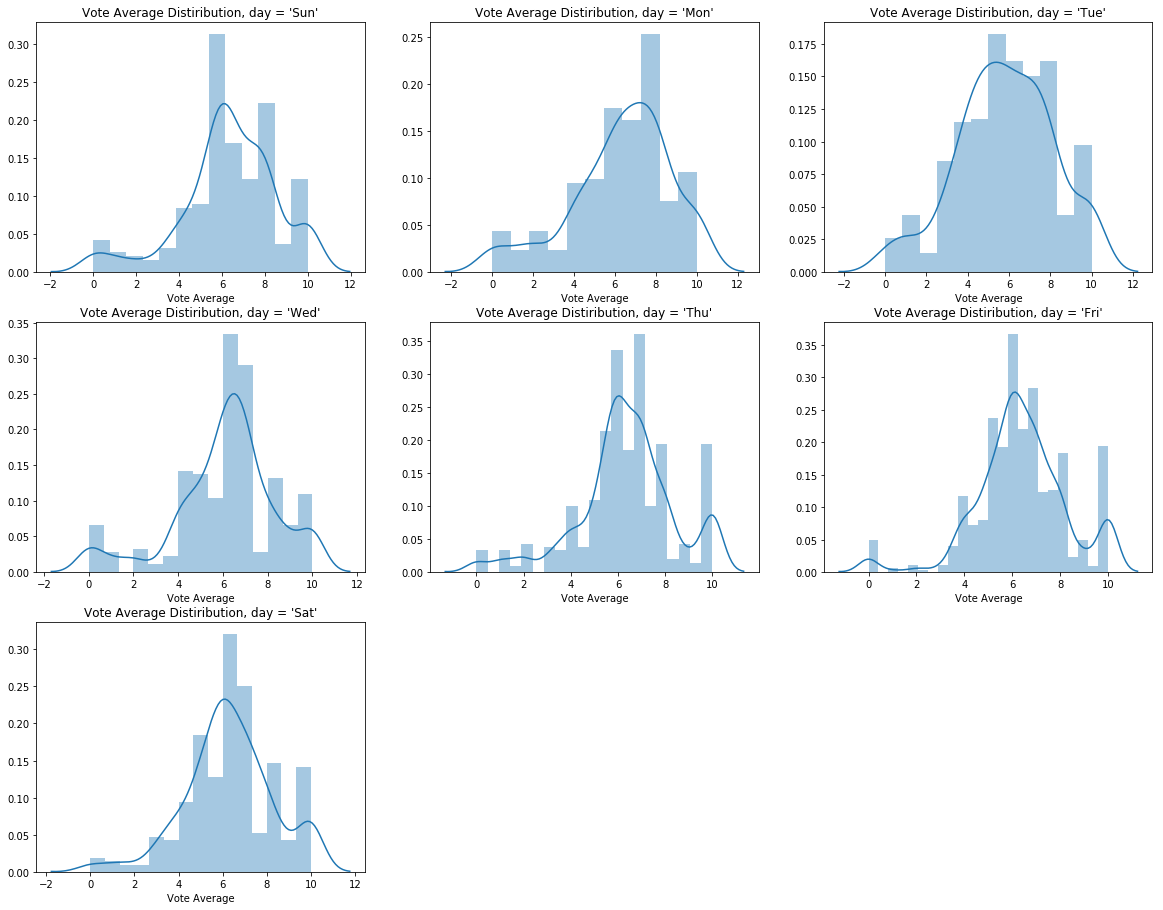

In [44]:
plt.figure(figsize=[20, 8])
i = 1
for day in ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]:
    plt.subplot(3, 3, i)
    sns.distplot(movies[movies["day_of_week"] == day]["vote_average"])
    plt.title("Vote Average Distiribution, day = '{}'".format(day))
    plt.xlabel("Vote Average")
    plt.subplots_adjust(top=1.6)
    i += 1
plt.savefig("../figures/ratings-dist-by-day-of-week.png", bbox_inches="tight");

These distributions are relatively different from one another, so it may be a good idea to one-hot encode this variable for use as a feature (this will be done in the next notebook).

Now we want to plot a scatterplot to get an idea of whether or not the day of the month on which the movie was released affects its ratings. The alpha of the points was lowered to combat overplotting problems.

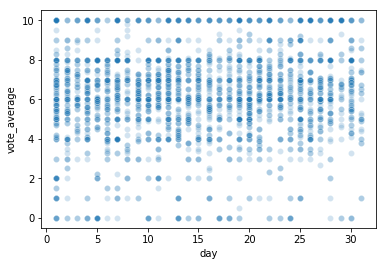

In [31]:
sns.scatterplot("day", "vote_average", data=movies, alpha=0.2);

There doesn't seem to be a clear relationship, so now we turn the the month. The $x$-axis is jittered and the opacity is lowered to combat overplotting problems.

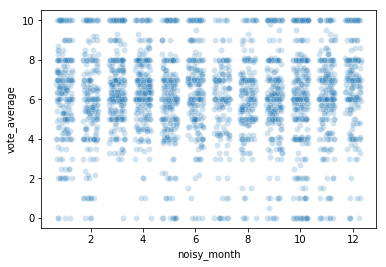

In [32]:
jitter = np.random.uniform(-.3, .3, movies.shape[0])
movies["noisy_month"] = movies["month"] + jitter
sns.scatterplot("noisy_month", "vote_average", data=movies, alpha=0.2);

As with the day of the month, there doesn't seem to be a huge effect based on the release month.

The next portion of this project is to build the linear regression predictor, which is done in the [`linear-regression-model` notebook](linear-regression-model.ipynb). We export the cleaned data in the cell below so that it can be used in that notebook.

In [47]:
movies.to_csv("../data/cleaned_movie_data.csv", index=False)